In [110]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import openml
import datetime

import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats
import numpy as np
import pandas as pd
import itertools as it
from tqdm.notebook import tqdm
import pickle

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

# Preliminaries

## Read Result Data

In [111]:
dfResults = pd.read_csv("results_final.csv")
dfResults

,timeout,openmlid,seed,algorithm,metric
0,85000,1485,0,rf,0.600788
1,85000,1485,0,random,0.373946
2,85000,1590,0,rf,0.570204
3,85000,1485,0,auto-sklearn,0.288015
4,85000,1590,0,random,0.358099
...,...,...,...,...,...
3414,85000,31,9,random,0.443728
3415,85000,1067,9,semi-naive,0.375751
3416,85000,31,6,semi-naive,0.694487
3417,85000,40975,8,semi-naive,0.014152


In [112]:
with open('performancecurves.pickle', 'rb') as handle:
    b = pickle.load(handle)
    performance_curves_1d = b["1d"]
    
TIME_LIMIT_HOUR = 3600
TIME_LIMIT_DAY = 85000

In [113]:
performance_curves_1h = {}
for openmlid in performance_curves_1d:
    performance_curves_1h[openmlid] = {}
    for algo in performance_curves_1d[openmlid]:
        performance_curves_1h[openmlid][algo] = {}
        if "times" in performance_curves_1d[openmlid][algo]:
            matches = np.where(performance_curves_1d[openmlid][algo]["times"] <= 3600)[0]
            if len(matches) > 0:
                cutoff_index = matches[-1]
                performance_curves_1h[openmlid][algo]["times"] = performance_curves_1d[openmlid][algo]["times"][:cutoff_index]
                performance_curves_1h[openmlid][algo]["values"] = performance_curves_1d[openmlid][algo]["values"][:cutoff_index]

In [114]:
OPTIMIZERS = ["rf", "random", "auto-sklearn", "gama", "naive", "semi-naive"]
OPTIMIZER_COLORS = {"rf": "C4", "random": "C5", "auto-sklearn": "C0", "gama": "C1", "naive": "C2", "semi-naive": "C3"}
OPTIMIZER_NAMES = {"rf": "rf", "random": "random", "auto-sklearn": "auto-sklearn", "gama": "GAMA", "naive": "naive", "semi-naive": "quasi-naive"}

datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]
datasets_sparse = [d for d in [1590, 1486, 4541, 4534, 4135, 40978, 40670, 1111, 42732, 42734, 41162, 41143, 41147, 3, 188, 1461, 42733, 40668] if d in datasets]
#metrics = {1485: 'auc', 1590: 'auc', 1515: 'log_loss', 1457: 'log_loss', 1475: 'log_loss', 1468: 'log_loss', 1486: 'auc', 1489: 'auc', 23512: 'auc', 23517: 'auc', 4541: 'log_loss', 4534: 'auc', 4538: 'log_loss', 4134: 'auc', 4135: 'auc', 40978: 'auc', 40996: 'log_loss', 41027: 'log_loss', 40981: 'auc', 40982: 'log_loss', 40983: 'auc', 40984: 'log_loss', 40701: 'auc', 40670: 'log_loss', 40685: 'log_loss', 40900: 'auc', 1111: 'auc', 42732: 'auc', 42733: 'auc', 42734: 'log_loss', 40498: 'log_loss', 41161: 'auc', 41162: 'auc', 41163: 'log_loss', 41164: 'log_loss', 41165: 'log_loss', 41166: 'log_loss', 41167: 'log_loss', 41168: 'log_loss', 41169: 'log_loss', 41142: 'auc', 41143: 'auc', 41144: 'auc', 41145: 'auc', 41146: 'auc', 41147: 'auc', 41150: 'auc', 41156: 'auc', 41157: 'auc', 41158: 'auc', 41159: 'auc', 41138: 'auc', 54: 'log_loss', 181: 'log_loss', 188: 'log_loss', 1461: 'auc', 1494: 'auc', 1464: 'auc', 12: 'log_loss', 23: 'log_loss', 3: 'auc', 1487: 'auc', 40668: 'log_loss', 1067: 'auc', 1049: 'auc', 40975: 'log_loss', 31: 'auc'}
metrics = {i: "log_loss" for i in datasets}
datasetnames = {1485: 'madelon', 1590: 'adult', 1515: 'micro-mass', 1457: 'amazon-commerce-reviews', 1475: 'first-order-theorem-proving', 1468: 'cnae-9', 1486: 'nomao', 1489: 'phoneme', 23512: 'higgs', 23517: 'numerai28.6', 4541: 'Diabetes130US', 4534: 'PhishingWebsites', 4538: 'GesturePhaseSegmentationProcessed', 4134: 'Bioresponse', 4135: 'Amazon_employee_access', 40978: 'Internet-Advertisements', 40996: 'Fashion-MNIST', 41027: 'jungle_chess_2pcs_raw_endgame_complete', 40981: 'Australian', 40982: 'steel-plates-fault', 40983: 'wilt', 40984: 'segment', 40701: 'churn', 40670: 'dna', 40685: 'shuttle', 40900: 'Satellite', 1111: 'KDDCup09_appetency', 42732: 'sf-police-incidents', 42733: 'Click_prediction_small', 42734: 'okcupid-stem', 40498: 'wine-quality-white', 41161: 'riccardo', 41162: 'kick', 41163: 'dilbert', 41164: 'fabert', 41165: 'robert', 41166: 'volkert', 41167: 'dionis', 41168: 'jannis', 41169: 'helena', 41142: 'christine', 41143: 'jasmine', 41144: 'madeline', 41145: 'philippine', 41146: 'sylvine', 41147: 'albert', 41150: 'MiniBooNE', 41156: 'ada', 41157: 'arcene', 41158: 'gina', 41159: 'guillermo', 41138: 'APSFailure', 54: 'vehicle', 181: 'yeast', 188: 'eucalyptus', 1461: 'bank-marketing', 1494: 'qsar-biodeg', 1464: 'blood-transfusion-service-center', 12: 'mfeat-factors', 23: 'cmc', 3: 'kr-vs-kp', 1487: 'ozone-level-8hr', 40668: 'connect-4', 1067: 'kc1', 1049: 'pc4', 40975: 'car', 31: 'credit-g'}
datasets_auc = [i for i, metric in metrics.items() if metric == "auc"]
datasets_logloss = [i for i, metric in metrics.items() if metric == "log_loss"]

In [116]:
alarms = []
for timeout in [TIME_LIMIT_HOUR, TIME_LIMIT_DAY]:
    for openmlid in datasets:
        for algo in OPTIMIZERS:
            cnt = len(dfResults[(dfResults["timeout"] == timeout) & (dfResults["algorithm"] == algo) & (dfResults["openmlid"] == openmlid)])
            if cnt < 2:
                print("Alarm for ", algo + " on " + str(openmlid) + " for timeout " + str(timeout) + ":", cnt)

Alarm for  rf on 1485 for timeout 3600: 0
Alarm for  random on 1485 for timeout 3600: 0
Alarm for  auto-sklearn on 1485 for timeout 3600: 0
Alarm for  gama on 1485 for timeout 3600: 0
Alarm for  naive on 1485 for timeout 3600: 0
Alarm for  semi-naive on 1485 for timeout 3600: 0
Alarm for  rf on 1590 for timeout 3600: 0
Alarm for  random on 1590 for timeout 3600: 0
Alarm for  auto-sklearn on 1590 for timeout 3600: 0
Alarm for  gama on 1590 for timeout 3600: 0
Alarm for  naive on 1590 for timeout 3600: 0
Alarm for  semi-naive on 1590 for timeout 3600: 0
Alarm for  rf on 1515 for timeout 3600: 0
Alarm for  random on 1515 for timeout 3600: 0
Alarm for  auto-sklearn on 1515 for timeout 3600: 0
Alarm for  gama on 1515 for timeout 3600: 0
Alarm for  naive on 1515 for timeout 3600: 0
Alarm for  semi-naive on 1515 for timeout 3600: 0
Alarm for  rf on 1457 for timeout 3600: 0
Alarm for  random on 1457 for timeout 3600: 0
Alarm for  auto-sklearn on 1457 for timeout 3600: 0
Alarm for  gama on 1457

Alarm for  semi-naive on 40498 for timeout 3600: 0
Alarm for  rf on 41161 for timeout 3600: 0
Alarm for  random on 41161 for timeout 3600: 0
Alarm for  auto-sklearn on 41161 for timeout 3600: 0
Alarm for  gama on 41161 for timeout 3600: 0
Alarm for  naive on 41161 for timeout 3600: 0
Alarm for  semi-naive on 41161 for timeout 3600: 0
Alarm for  rf on 41163 for timeout 3600: 0
Alarm for  random on 41163 for timeout 3600: 0
Alarm for  auto-sklearn on 41163 for timeout 3600: 0
Alarm for  gama on 41163 for timeout 3600: 0
Alarm for  naive on 41163 for timeout 3600: 0
Alarm for  semi-naive on 41163 for timeout 3600: 0
Alarm for  rf on 41164 for timeout 3600: 0
Alarm for  random on 41164 for timeout 3600: 0
Alarm for  auto-sklearn on 41164 for timeout 3600: 0
Alarm for  gama on 41164 for timeout 3600: 0
Alarm for  naive on 41164 for timeout 3600: 0
Alarm for  semi-naive on 41164 for timeout 3600: 0
Alarm for  rf on 41165 for timeout 3600: 0
Alarm for  random on 41165 for timeout 3600: 0
Alar

Alarm for  auto-sklearn on 1067 for timeout 3600: 0
Alarm for  gama on 1067 for timeout 3600: 0
Alarm for  naive on 1067 for timeout 3600: 0
Alarm for  semi-naive on 1067 for timeout 3600: 0
Alarm for  rf on 1049 for timeout 3600: 0
Alarm for  random on 1049 for timeout 3600: 0
Alarm for  auto-sklearn on 1049 for timeout 3600: 0
Alarm for  gama on 1049 for timeout 3600: 0
Alarm for  naive on 1049 for timeout 3600: 0
Alarm for  semi-naive on 1049 for timeout 3600: 0
Alarm for  rf on 40975 for timeout 3600: 0
Alarm for  random on 40975 for timeout 3600: 0
Alarm for  auto-sklearn on 40975 for timeout 3600: 0
Alarm for  gama on 40975 for timeout 3600: 0
Alarm for  naive on 40975 for timeout 3600: 0
Alarm for  semi-naive on 40975 for timeout 3600: 0
Alarm for  rf on 31 for timeout 3600: 0
Alarm for  random on 31 for timeout 3600: 0
Alarm for  auto-sklearn on 31 for timeout 3600: 0
Alarm for  gama on 31 for timeout 3600: 0
Alarm for  naive on 31 for timeout 3600: 0
Alarm for  semi-naive on 3

## Compute metrics to be used for the different datasets

# Computation of Performance Curves of the Optimizers

In [117]:
def get_rank_curves(performance_curves_per_dataset):
    
    # get all algorithms and times
    algos = None
    times = set([])
    for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
        algos_here = set(performance_curves_of_dataset.keys())
        if algos is None:
            algos = algos_here
        elif algos != algos_here:
            raise Exception("Inconsistent algorithm set! Current is " + str(algos) + " but local is " + str(algos_here))
        for algo, curve in performance_curves_of_dataset.items():
            if not "times" in curve:
                print(f"Empty curve set for dataset {openmlid} on algorithm {algo}")
                continue
            for t in curve["times"]:
                times.add(t)
    if algos is None:
        raise Exception("No algorithms observed ...")
    times = sorted(list(times))
    algos = sorted(list(algos))
    
    # now create average rank score for each point in time
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in algos} for openmlid in performance_curves_per_dataset.keys()}
    mean_rank_curves = []
    q1_rank_curves = []
    q3_rank_curves = []
    for t in tqdm(times):
        ranks_at_t = []
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            considered_algos_for_timestep_and_dataset = []
            for algorithm, curve in performance_curves_of_dataset.items():
                if not "times" in curve:
                    print(f"Empty curve set for dataset {openmlid} and algorithm {algorithm}")
                    continue
                considered_algos_for_timestep_and_dataset.append(algorithm)
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    cur_vals[algorithm] = scipy.stats.trim_mean(np.round(curve["values"][index_of_timestamp], 2), 0.1)
            
            # only consider this time step if all values are available
            if len(considered_algos_for_timestep_and_dataset) == len(algos):
                ranks_at_t.append(list(scipy.stats.rankdata(-np.array([cur_vals[algo] for algo in algos]))))
                
        mean_rank_curves.append(list(np.mean(np.array(ranks_at_t), axis=0)))
        q1_rank_curves.append(list(np.percentile(np.array(ranks_at_t), 25, axis=0)))
        q3_rank_curves.append(list(np.percentile(np.array(ranks_at_t), 75, axis=0)))
    return algos, times, np.array(mean_rank_curves), np.array(q1_rank_curves), np.array(q3_rank_curves)


def get_algos_and_times_for_curveset(curveset):
    
    # get all algorithms and times
    algos = None
    times = set([])
    for openmlid, performance_curves_of_dataset in curveset.items():
        algos_here = set(performance_curves_of_dataset.keys())
        if algos is None:
            algos = algos_here
        elif algos != algos_here:
            raise Exception("Inconsistent algorithm set! Current is " + str(algos) + " but local is " + str(algos_here))
        for curve in performance_curves_of_dataset.values():
            if not "times" in curve:
                print(f"Empty curve set for dataset {openmlid}")
                continue
            for t in curve["times"]:
                times.add(t)
                
    if algos is None:
        raise Exception(f"No algorithms observed in curveset {curveset}")
    times = sorted(list(times))
    algos = sorted(list(algos))
    return algos, times

def get_win_curves(performance_curves_per_dataset, algo_1, algo_2):
    
    algos, times = get_algos_and_times_for_curveset(performance_curves_per_dataset)
    
    # now create win counts for each point in time
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in [algo_1, algo_2]} for openmlid in performance_curves_per_dataset.keys()}
    wins_1 = []
    wins_2 = []
    for t in tqdm(times):
        wins_at_t_algo1 = 0
        wins_at_t_algo2 = 0
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            for algo in [algo_1, algo_2]:
                curve = performance_curves_of_dataset[algo]
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    val = np.median(curve["values"][index_of_timestamp])
                    if np.isnan(val):
                        val = -np.inf
                    cur_vals[algo] = val
            if cur_vals[algo_1] >= cur_vals[algo_2]:
                wins_at_t_algo1 +=1
            if cur_vals[algo_2] >= cur_vals[algo_1]:
                wins_at_t_algo2 +=1
        wins_1.append(wins_at_t_algo1)
        wins_2.append(wins_at_t_algo2)
        
    return times, np.array([wins_1, wins_2])



def get_relative_curves_per_dataset(performance_curves_per_dataset, baseline):
    algos, times = get_algos_and_times_for_curveset(performance_curves_per_dataset)
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in algos} for openmlid in performance_curves_per_dataset.keys()}
    
    diff_curves = {openmlid: {algo: [] for algo in algos if algo != baseline} for openmlid in performance_curves_per_dataset.keys()}
    
    for t in tqdm(times):
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            
            # compute values of all curves at point of time
            cur_vals = cur_vals_per_dataset[openmlid]
            for algo in algos:
                curve = performance_curves_of_dataset[algo]
                if not "times" in curve:
                    print(f"Empty curve set for dataset {openmlid}")
                    continue
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    val = np.median(curve["values"][index_of_timestamp], axis=0)
                    if np.isnan(val):
                        val = -np.inf
                    cur_vals[algo] = val
            
            # now compare
            base_val = cur_vals[baseline]
            for algo in algos:
                if algo != baseline:
                    if base_val == -np.inf:
                        if cur_vals[algo] == -np.inf:
                            diff = 0
                        else:
                            diff = -1 if openmlid in datasets_auc else - 5
                    else:
                        if cur_vals[algo] == -np.inf:
                            diff = 1 if openmlid in datasets_auc else 5
                        else:
                            diff = base_val - cur_vals[algo]
                    diff_curves[openmlid][algo].append(diff)
    
    return {"times": times, "algos": algos, "comparisons": diff_curves}

In [118]:
diff_curves = get_relative_curves_per_dataset(performance_curves_1d, "semi-naive")

  0%|          | 0/18722 [00:00<?, ?it/s]

In [119]:
#comparison_summary_auc = {algo: np.nanmean([diff_curves["comparisons"][openmlid][algo] for openmlid in datasets_auc], axis=0) for algo in diff_curves["algos"] if algo != "semi-naive"}
comparison_summary_logloss = {algo: np.nanmean([diff_curves["comparisons"][openmlid][algo] for openmlid in datasets_logloss if openmlid in diff_curves["comparisons"]], axis=0) for algo in diff_curves["algos"] if algo != "semi-naive"}

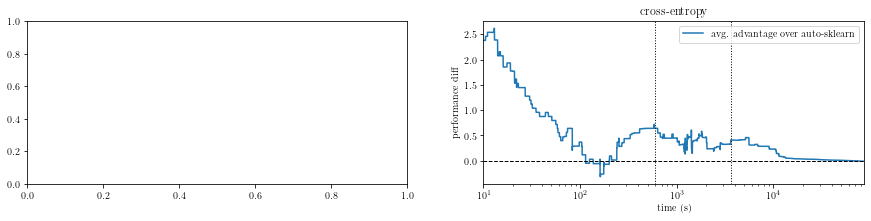

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
for comp in ["auto-sklearn"]:#, "gama"]:
    #ax[0].plot(diff_curves["times"], comparison_summary_auc[comp], label="avg. advantage over " + comp)
    ax[1].plot(diff_curves["times"], comparison_summary_logloss[comp], label="avg. advantage over " + comp)
for i, title in enumerate(["AUROC", "cross-entropy"]):
    if i == 0:
        continue
    ax[i].axhline(0, linestyle="--", color="black", linewidth=1)
    ax[i].set_xscale("log")
    ax[i].set_xlim([10, 86400])
    ax[i].legend()
    ax[i].set_xlabel("time (s)")
    ax[i].set_ylabel("performance diff")
    ax[i].axvline(600, linestyle="dotted", color="black", linewidth=1)
    ax[i].axvline(3600, linestyle="dotted", color="black", linewidth=1)
    ax[i].set_title(title)
fig.savefig("plots/advantage-sklearn.jpg", bbox_inches='tight')

# Result Visualizations In Main Paper

## Avg Rank Plots Over Time and Final Performances

In [121]:
def plot_ranks(avg_rank_curves, ax, algorithm_order = None, log_scale = True):
    algos = avg_rank_curves[0] if algorithm_order is None else algorithm_order
    times = avg_rank_curves[1]
    mean_curves = avg_rank_curves[2]
    q1_curves = avg_rank_curves[3]
    q3_curves = avg_rank_curves[4]
    
    for algo in algos:
        index = avg_rank_curves[0].index(algo)
        ax.plot(times, mean_curves[:,index], color=OPTIMIZER_COLORS[algo], label=OPTIMIZER_NAMES[algo])
        ax.fill_between(times, q1_curves[:,index], q3_curves[:,index], alpha=0.1)
    #ax.legend()
    ax.set_ylim([1, len(algos)])
    if log_scale:
        ax.set_xlim([100, times[-1] + 300])
        ax.set_xscale("log")

In [122]:
def get_final_results(df, timeout):
    df = df[df["timeout"] == timeout]
    algos = list(pd.unique(df["algorithm"]))
    
    results = {}
    
    for openmlid, dfDataset in df.groupby("openmlid"):
        metric = metrics[openmlid]
        if not metric in results:
            results[metric] = {}
        results[metric][openmlid] = {}
        for algo in algos:
            results[metric][openmlid][algo] = dfDataset[dfDataset["algorithm"] == algo]["metric"].values
            
    return results

def plot_final_results_as_boxplot_per_dataset(results, ax_auc, ax_logloss):
    
    from pylab import setp
    
    for metric in ["auc", "log_loss"]:
        for openmlid in results[metric]:
            boxplots = []
            labels = []
            for algo in results[metric][openmlid]:
                boxplots.append(results[metric][openmlid][algo])
                labels.append(OPTIMIZER_NAMES[algo])
            fig, ax = plt.subplots()
            ax.boxplot(boxplots)
            ax.set_title(str(openmlid) + " (" + metric + ")")
            ax.set_xticklabels(labels)
            plt.show()

def plot_final_results_as_rank_boxplot(results, algos, ax):
    
    all_ranks = []
    for metric in ["auc", "log_loss"]:
        if metric in results:
            for openmlid in results[metric]:
                scores = []
                for algo in algos:
                    score = np.nanmedian(results[metric][openmlid][algo])
                    score = np.round(score, 2)# if metric == "auc" else 1)
                    scores.append(score)

                data_to_rank = np.array(scores) if metric is "log_loss" else -np.array(scores)
                ranks = list(scipy.stats.rankdata(data_to_rank))
                all_ranks.append(ranks)
            else:
                print(f"Warning, there is no entry for metric {metric}, ignoring it.")
                
        
    # create plot
    ax.violinplot(np.array(all_ranks), showmedians=True)
    ax.set_xticks(range(1, 1 + len(algos)))
    ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
        
def plot_final_results_as_rank_boxplot_per_metric(results, ax_auc, ax_logloss):
    
    from pylab import setp
    
    for metric in ["auc", "log_loss"]:
        all_ranks = []
        algos = None
        if metric in results:
            for openmlid in results[metric]:
                scores = []
                algos_here = []
                for algo in results[metric][openmlid]:
                    score = np.nanmedian(results[metric][openmlid][algo])
                    score = np.round(score, 2)
                    scores.append(score)
                    algos_here.append(algo)
                if algos is None:
                    algos = algos_here
                elif algos != algos_here:
                    raise Exception("Inconsistent algorithm order!")

                data_to_rank = np.array(scores) if metric is "log_loss" else -np.array(scores)
                ranks = list(scipy.stats.rankdata(data_to_rank))
                all_ranks.append(ranks)
        else:
            print(f"Warning, there is no entry for metric {metric}, ignoring it.")
        
        # create plot
        ax = ax_auc if metric == "auc" else ax_logloss
        ax.violinplot(np.array(all_ranks))
        ax.set_title(metric)
        ax.set_xticks(range(1, 1 + len(algos)))
        ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
        
def get_plot_ofrank_curves_and_violines(avg_rank_curves, algorithm_order, df, timeout, log_scale):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    plot_ranks(avg_rank_curves, ax1, algorithm_order=algorithm_order, log_scale=log_scale)
    ax1.set_ylabel("Validation Rank")
    ax1.set_xlabel("Runtime (s)")
    plot_final_results_as_rank_boxplot(get_final_results(df[df["algorithm"].isin(algorithm_order)], timeout), algorithm_order, ax2)
    ax2.set_ylabel("Test Rank")
    fig.tight_layout()
    return fig, (ax1, ax2)
    

In [123]:
def get_empirical_gaps_over_time(performance_curves):
    
    curves_for_auc = performance_curves
    algos, times = get_algos_and_times_for_curveset(curves_for_auc)
    datasets = curves_for_auc.keys()
    
    cur_vals_per_dataset = {openmlid: {algo: -np.inf for algo in algos} for openmlid in datasets}
    sup_curves = {openmlid: [] for openmlid in datasets}
    values = {algo: [] for algo in algos}
    
    for t_index, t in enumerate(tqdm(times)):
        gaps_at_t = {}
        for openmlid, performance_curves_of_dataset in curves_for_auc.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            for algorithm, curve in performance_curves_of_dataset.items():
                if "times" in curve and t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    cur_vals[algorithm] = np.median(curve["values"][index_of_timestamp])
            
            best_value_at_t = max(cur_vals.values())
            gaps_at_t[openmlid] = {algorithm: min(1, best_value_at_t - cur_vals[algorithm]) if best_value_at_t > -np.inf else 0 for algorithm in algos}
            sup_curves[openmlid].append(best_value_at_t)
            
        for algo in algos:
            gaps_of_algo_at_time = [gaps_at_t[openmlid][algo] for openmlid in datasets]
            values[algo].append(gaps_of_algo_at_time)
            
    return times, values

def plot_empirical_gaps_over_time(empirical_gaps, ax):
    times, values = empirical_gaps
    for algo, curves_of_algo in values.items():
        color = OPTIMIZER_COLORS[algo]
        ax.step(times, np.mean(curves_of_algo, axis=1),  label=OPTIMIZER_NAMES[algo], color=color, linewidth=1)
        ax.step(times, np.percentile(curves_of_algo, 95, axis=1), linestyle="dotted", color=color, linewidth=1)
        ax.step(times, np.percentile(curves_of_algo, 75, axis=1), linestyle="--", color=color, linewidth=1)
        ax.fill_between(times, np.percentile(curves_of_algo, 25, axis=1), np.percentile(curves_of_algo, 75, axis=1), color=color, alpha=0.1)

## Compute All Curves

In [124]:
rank_curves_1h = get_rank_curves(performance_curves_1h)
rank_curves_1d = get_rank_curves(performance_curves_1d)

Empty curve set for dataset 42732 on algorithm rf


  0%|          | 0/9622 [00:00<?, ?it/s]

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

  0%|          | 0/18722 [00:00<?, ?it/s]

In [125]:
empirical_gaps_1h = get_empirical_gaps_over_time(performance_curves_1h)
empirical_gaps_1d = get_empirical_gaps_over_time(performance_curves_1d)

Empty curve set for dataset 42732


  0%|          | 0/9622 [00:00<?, ?it/s]

  0%|          | 0/18722 [00:00<?, ?it/s]

## Create Plots

### 1h Time Limit

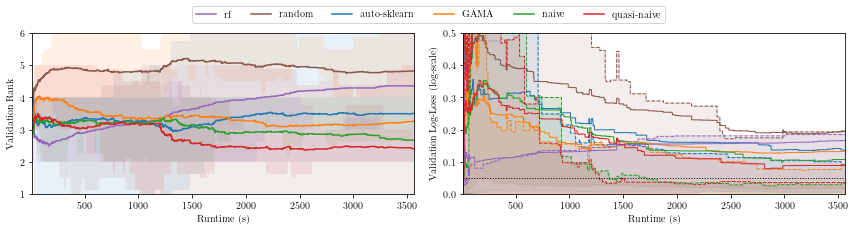

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# left plot: ranks
plot_ranks(rank_curves_1h, ax1, algorithm_order=OPTIMIZERS, log_scale=False)
ax1.set_ylabel("Validation Rank")
ax1.set_xlim([10, TIME_LIMIT_HOUR * .99])
ax1.set_xlabel("Runtime (s)")

# right plot: empirical gaps
plot_empirical_gaps_over_time(empirical_gaps_1h, ax2)
ax2.set_ylabel("Validation Log-Loss (log-scale)")
ax2.set_xlabel("Runtime (s)")
ax2.set_ylim([0, .5])
#ax2.set_ylim([10**-3, 1])
#ax2.set_yscale("log")
ax2.axhline(0.05, linestyle="dotted", color="black", linewidth=1)
ax2.set_xlim([10, TIME_LIMIT_HOUR * .99])

# create legend
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=6)

fig.tight_layout()
fig.savefig("plots/ranks-1h.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### 1d Time Limit

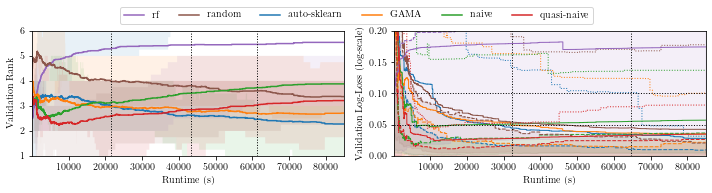

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))

# left plot: ranks
plot_ranks(rank_curves_1d, ax1, algorithm_order=OPTIMIZERS, log_scale=False)
ax1.set_ylabel("Validation Rank")
ax1.set_xlim([10, TIME_LIMIT_DAY])
#ax1.set_xscale("log")
ax1.axvline(3600 * 6, linestyle="dotted", linewidth=1, color="black")
ax1.axvline(3600 * 12, linestyle="dotted", linewidth=1, color="black")
ax1.axvline(3600 * 17, linestyle="dotted", linewidth=1, color="black")
ax1.set_xlabel("Runtime (s)")

# right plot: empirical gaps
plot_empirical_gaps_over_time(empirical_gaps_1d, ax2)
ax2.set_ylabel("Validation Log-Loss (log-scale)")
ax2.set_xlabel("Runtime (s)")
ax2.set_ylim([0, .2])
#ax2.set_ylim([10**-3, 1])
#ax2.set_yscale("log")
ax2.axvline(3600 * 9, linestyle="dotted", linewidth=1, color="black")
ax2.axvline(3600 * 18, linestyle="dotted", linewidth=1, color="black")
#ax2.axhline(0.01, linestyle="dotted", linewidth=1, color="black")
#ax2.legend()
ax2.axhline(0.1, linestyle="dotted", color="black", linewidth=1)
ax2.axhline(0.05, linestyle="dotted", color="black", linewidth=1)
#ax2.axhline(0.01, linestyle="dotted", color="black", linewidth=1)
ax2.set_xlim([10, TIME_LIMIT_DAY])
#ax2.set_xscale("log")

# create legend
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=6)

fig.tight_layout()
fig.savefig("plots/ranks-1d.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Test Performance Gaps to Best (Only for 1d)

In [128]:
def get_optimality_gaps(df):
    gaps = {}
    for openmlid, dfDataset in df.groupby("openmlid"):
        is_max = metrics[openmlid] == "auc"
        medians = {algorithm: np.nanmedian(dfAlgo["metric"].values) for algorithm, dfAlgo in dfDataset.groupby("algorithm")}
        best_median = max(medians.values()) if is_max else min(medians.values())
        gaps_on_dataset = {algo: best_median - median if is_max else median - best_median for algo, median in medians.items()}
        gaps[openmlid] = gaps_on_dataset
    return gaps

def get_gap_plot_for_computed_gaps(gaps, ax):
    
    if len(gaps) == 0:
        return
    
    # compute gaps per algorithm
    gaps_per_algorithm = {}
    for openmlid, gaps_for_dataset in gaps.items():        
        for algo, gap in gaps_for_dataset.items():
            if not algo in gaps_per_algorithm:
                gaps_per_algorithm[algo] = []
            gaps_per_algorithm[algo].append(gap)
    
    # create violinplot
    algos = OPTIMIZERS
    ax.violinplot([gaps_per_algorithm[algo] for algo in algos], showmedians=True, quantiles=[[.5, .9] for i in range(len(algos))])
    ax.set_xticks(range(1, len(algos) + 1))
    ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
    

def get_gap_plots(df, timeout):    
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    gaps = get_optimality_gaps(df[dfResults["timeout"] == timeout])
    gaps_for_auc = {openmlid: gaps_of_id for openmlid, gaps_of_id in gaps.items() if metrics[openmlid] == "auc"}
    get_gap_plot_for_computed_gaps(gaps_for_auc, ax[0])
    ax[0].set_ylim([0, 0.1])
    ax[0].set_title("Gaps on AUROC datasets")
    gaps_for_log_loss = {openmlid: gaps_of_id for openmlid, gaps_of_id in gaps.items() if metrics[openmlid] == "log_loss"}
    get_gap_plot_for_computed_gaps(gaps_for_log_loss, ax[1])
    ax[1].set_ylim([0, .2])
    ax[1].set_title("Gaps on log-loss datasets")
    return fig, ax

Warning, there is no entry for metric log_loss, ignoring it.


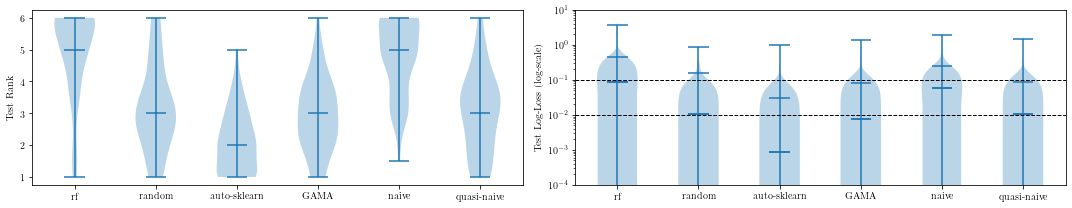

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
gaps = get_optimality_gaps(dfResults[dfResults["timeout"] == TIME_LIMIT_DAY])

# rank gaps
plot_final_results_as_rank_boxplot(get_final_results(dfResults[dfResults["algorithm"].isin(OPTIMIZERS)], TIME_LIMIT_DAY), OPTIMIZERS, ax[0])
ax[0].set_ylabel("Test Rank")

# absolute gaps
get_gap_plot_for_computed_gaps(gaps, ax[1])
ax[1].set_ylim([10**-4, 10.0])
ax[1].set_yscale("log")
#ax[1].set_ylim([0, 0.1])
ax[1].set_ylabel("Test Log-Loss (log-scale)")
ax[1].axhline(0.1, linestyle="--", linewidth=1, color="black")
ax[1].axhline(0.01, linestyle="--", linewidth=1, color="black")

fig.tight_layout()
fig.savefig("plots/gaps-1d.pdf")
plt.show()

In [121]:
print(np.percentile([v["semi-naive"] for k,v in gaps.items()], 80))

0.04984579286166715


## Grid Search Results

In [101]:
import json

In [158]:
dfGrid = pd.read_csv("gridsearchresults.csv", delimiter=";")
#dfGrid[(dfGrid["exception"].notna())]
dfGrid = dfGrid[(dfGrid["exception"].isna()) & (dfGrid["metric"].notna())]
dfGrid

,experiment_id,openmlid,seed,algorithm,timeout_total,timeout_evaluation,cpus,memory_max,time_created,host,executor,time_started,chosenmodel,errorrate,metric,onlinedata,exception,time_end
0,5123,3,1,grid,85000,1200,2,24000,2021-12-14 21:55:30,node09-037,oculus-9875192-168,2021-12-17 10:29:30,"Pipeline(steps=[('data-pre-processor', Varianc...",0.003125,0.009296,"[[1.7011158466339111, ""Pipeline(steps=[('class...",NaN,2021-12-17 11:06:31
1,5130,3,2,grid,85000,1200,2,24000,2021-12-14 21:55:30,node03-008,oculus-9875192-177,2021-12-17 05:53:41,"Pipeline(steps=[('classifier',\n ...",0.003125,0.012337,"[[1.908933401107788, ""Pipeline(steps=[('classi...",NaN,2021-12-17 06:30:50
2,5143,3,3,grid,85000,1200,2,24000,2021-12-14 21:55:30,node03-026,oculus-9875192-191,2021-12-17 05:04:50,"Pipeline(steps=[('data-pre-processor', Quantil...",0.000000,0.004106,"[[1.6672570705413818, ""Pipeline(steps=[('class...",NaN,2021-12-17 05:42:24
3,5150,3,4,grid,85000,1200,2,24000,2021-12-14 21:55:30,node02-016,oculus-9875192-151,2021-12-17 13:27:24,"Pipeline(steps=[('feature-pre-processor', Poly...",0.003125,0.004707,"[[1.7069385051727295, ""Pipeline(steps=[('class...",NaN,2021-12-17 14:05:20
4,5155,3,5,grid,85000,1200,2,24000,2021-12-14 21:55:30,node03-009,oculus-9875192-176,2021-12-17 10:52:25,"Pipeline(steps=[('data-pre-processor', Quantil...",0.003125,0.013707,"[[1.6865899562835693, ""Pipeline(steps=[('class...",NaN,2021-12-17 11:29:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,4914,42734,6,grid,85000,1200,2,24000,2021-12-14 21:55:30,node02-027,oculus-9875192-20,2021-12-16 00:09:35,"Pipeline(steps=[('data-pre-processor', Normali...",0.254971,0.589842,"[[2.386615753173828, ""Pipeline(steps=[('classi...",NaN,2021-12-16 07:33:55
546,4927,42734,7,grid,85000,1200,2,24000,2021-12-14 21:55:30,node05-023,oculus-9898210-12,2021-12-22 02:23:21,"Pipeline(steps=[('data-pre-processor', Normali...",0.251821,0.595430,"[[1.8796682357788086, ""Pipeline(steps=[('class...",NaN,2021-12-22 11:51:05
547,4936,42734,8,grid,85000,1200,2,24000,2021-12-14 21:55:30,node05-014,oculus-9875192-90,2021-12-16 00:09:38,"Pipeline(steps=[('data-pre-processor', Normali...",0.252412,0.584750,"[[2.372054100036621, ""Pipeline(steps=[('classi...",NaN,2021-12-16 07:36:07
548,4945,42734,9,grid,85000,1200,2,24000,2021-12-14 21:55:30,node07-004,oculus-9898210-8,2021-12-21 22:08:03,"Pipeline(steps=[('data-pre-processor', Normali...",0.259106,0.601450,"[[2.0698254108428955, ""Pipeline(steps=[('class...",NaN,2021-12-22 08:01:01


In [106]:
len(dfGrid)
from util import *

In [173]:
eps = 0.03
datasets_stripe = [d for d in datasets if d not in [41150, 41158, 41168]]

def get_code(algo):
    return str(algo) if algo.__class__ == sklearn.svm.SVC else str(algo.__class__)

hits = np.zeros((3, len(datasets_stripe)))
misses = np.zeros((3, len(datasets_stripe)))
for i, row in tqdm(dfGrid.iterrows()):
    
    if not row["openmlid"] in datasets_stripe:
        continue
    
    col_index = datasets_stripe.index(row["openmlid"])
    
    history = json.loads(row["onlinedata"])
    augmented_history = [(e[0], recover_pipeline(e[1]), e[2]["neg_log_loss"]) for e in history]
    
    # find best score in grid
    best_score = max([e[2]["neg_log_loss"] for e in history])
    eps_best_entries = [e for e in augmented_history if e[2] >= best_score - eps]
    
    # compute acceptable choice for each slot
    acceptable_choices = {}
    for time, pl, score in eps_best_entries:
        for step in ["data-pre-processor", "feature-pre-processor", "classifier"]:
            if not step in acceptable_choices:
                acceptable_choices[step] = set()
            
            if step in [s[0] for s in pl.steps]:
                acceptable_choices[step].add(get_code(pl[step]))
            else:
                acceptable_choices[step].add(None)
    
    # now check whether a greedy search would have chosen the correct classifier
    classifier_only_entries = [e for e in augmented_history if len(e[1].steps) == 1 and not np.isnan(e[2])]
    best_classifier_only_entry = classifier_only_entries[np.argmax([e[2] for e in classifier_only_entries])]
    best_classifier = best_classifier_only_entry[1]["classifier"]
    best_classifier_code = get_code(best_classifier)
    if best_classifier_code in acceptable_choices["classifier"]:
        hits[0,col_index] += 1
    else:
        misses[0,col_index] += 1
    
    # now check whether a greedy search would have chosen the correct data-pre-processor
    two_step_pipelines = [e for e in augmented_history if len(e[1].steps) == 2 and get_code(e[1]["classifier"]) == best_classifier_code and 'data-pre-processor' in [s[0] for s in e[1].steps] and not np.isnan(e[2])]
    if two_step_pipelines:
        chosen_two_step_entry = two_step_pipelines[np.argmax([e[2] for e in two_step_pipelines])]
        if chosen_two_step_entry[2] > best_classifier_only_entry[2]:
            chosen_data_preprocessor = get_code(chosen_two_step_entry[1]["data-pre-processor"])
        else:
            chosen_data_preprocessor = None
    else:
        chosen_data_preprocessor = None
    hit = chosen_data_preprocessor in acceptable_choices["data-pre-processor"]
    if hit:
        hits[1,col_index] += 1
    else:
        misses[1,col_index] += 1
    
    # now check whether a greedy search would have chosen the correct feature-pre-processor
    if chosen_data_preprocessor is None:
        complete_pipelines = [e for e in augmented_history if len(e[1].steps) == 2 and str(e[1]["classifier"]) == str(best_classifier) and 'feature-pre-processor' in [s[0] for s in e[1].steps] and not np.isnan(e[2])]
    else:
        complete_pipelines = [e for e in augmented_history if len(e[1].steps) == 3 and str(e[1]["classifier"]) == str(best_classifier) and get_code(e[1]["data-pre-processor"]) == chosen_data_preprocessor and not np.isnan(e[2])]
    best_full_entry = complete_pipelines[np.argmax([e[2] for e in complete_pipelines])] if complete_pipelines else None
    if best_full_entry is not None and best_full_entry[2] > max(chosen_two_step_entry[2], best_classifier_only_entry[2]):
        chosen_feature_preprocessor = get_code(best_full_entry[1]["feature-pre-processor"])
    else:
        chosen_feature_preprocessor = None
    hit = chosen_feature_preprocessor in acceptable_choices["feature-pre-processor"]
    if hit:
        hits[2,col_index] += 1
    else:
        misses[2,col_index] += 1

0it [00:00, ?it/s]

In [165]:
hits[:,datasets.index(41158)]

array([0., 0., 0.])

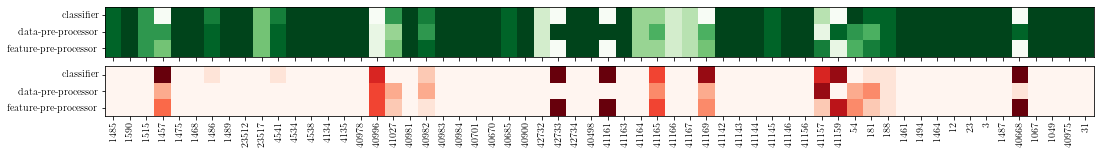

In [175]:
plot_progress = False


fig, ax = plt.subplots(2 + plot_progress, 1, figsize=(20, 2 + plot_progress), sharex=True)
ylabels = ["classifier", "data-pre-processor", "feature-pre-processor"]
if plot_progress:
    ax[0].imshow(-(hits + misses), cmap="seismic", vmin=-10, vmax=0)
    ax[0].set_xticks(range(len(datasets_stripe)))
    ax[0].set_xticklabels(datasets_stripe, rotation=90)
    ax[0].set_yticks(range(len(ylabels)))
    ax[0].set_yticklabels(ylabels)

(ax_hit, ax_miss) = ax[-2], ax[-1]

ax_hit.imshow(hits, cmap="Greens", vmin=0, vmax=10)
ax_hit.set_xticks(range(len(datasets_stripe)))
ax_hit.set_xticklabels(datasets_stripe, rotation=90)
ax_hit.set_yticks(range(len(ylabels)))
ax_hit.set_yticklabels(ylabels)

ax_miss.imshow(misses, cmap="Reds", vmin=0, vmax=10)
ax_miss.set_xticks(range(len(datasets_stripe)))
ax_miss.set_xticklabels(datasets_stripe, rotation=90)
ax_miss.set_yticks(range(len(ylabels)))
ax_miss.set_yticklabels(ylabels)

fig.savefig("plots/independence.pdf", bbox_inches='tight')
plt.show()

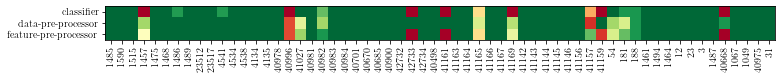

In [185]:
fig, ax = plt.subplots(figsize=(12, 2))
ylabels = ["classifier", "data-pre-processor", "feature-pre-processor"]
ax.imshow(hits / (hits + misses), cmap="RdYlGn", vmin=0, vmax=1)
ax.set_xticks(range(len(datasets_stripe)))
ax.set_xticklabels(datasets_stripe, rotation=90)
ax.set_yticks(range(len(ylabels)))
ax.set_yticklabels(ylabels)

fig.savefig("plots/independence.pdf", bbox_inches='tight')
plt.show()

In [162]:
(np.sum(hits) + np.sum(misses)) / (62*10*3)

0.8870967741935484

In [163]:
np.sum(hits) / (np.sum(hits) + np.sum(misses))

0.8818181818181818

# Appendix

## Dataset Descriptions

In [ ]:
datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]
rows = []
for openmlid in tqdm(datasets):
    
    # load dataset object
    dataset = openml.datasets.get_dataset(openmlid)
    
    # analyze columns of data
    dfDataset = dataset.get_data()[0]
    types = dfDataset.dtypes
    cnt_normalized = 0
    cnt_zero_mean = 0
    cnt_one_std = 0
    cnt_numerical = 0
    for i, col in enumerate(dfDataset.columns):
        if "float" in str(types[i]):
            cnt_numerical += 1
            vals = dfDataset[col].values
            is_normalized = np.round(min(vals), 3) == 0 and np.round(max(vals), 3) == 1
            is_zero_mean = np.round(np.mean(vals), 3) == 0
            is_one_std = np.round(np.std(vals), 3) == 1
            if is_normalized:
                cnt_normalized += 1
            if is_zero_mean:
                cnt_zero_mean += 1
            if is_one_std:
                cnt_one_std += 1
    if cnt_numerical > 0:
        feature_stats_entries = [str(v) + "\%" for v in np.round(100 * np.array([cnt_normalized / cnt_numerical, cnt_zero_mean / cnt_numerical, cnt_one_std / cnt_numerical]), 0).astype(int)]
    else:
        feature_stats_entries = 3 * ["n/a"]
        
    row = [openmlid, dataset.name[:20].replace("_", "\\_"), int(dataset.qualities["NumberOfInstances"]), len(dataset.features) - 1, int(dataset.qualities["NumberOfNumericFeatures"]), int(dataset.qualities["NumberOfClasses"]), str(int(dataset.qualities["MinorityClassPercentage"])) + "\%", str(int(dataset.qualities["MajorityClassPercentage"])) + "\%", str(int(dataset.qualities["PercentageOfMissingValues"])) + "\%"] + feature_stats_entries
    rows.append(row)
dfDatasets = pd.DataFrame(rows, columns=["openmlid", "name", "instances", "features", "numeric features", "classes", "min \%", "maj \%", "\% missing", "\% [0,1]", "\% $\mu = 0$", "\% $\sigma = 1$"]).sort_values("openmlid")

In [ ]:
print(dfDatasets.to_latex(index=False,escape=False))

In [ ]:
for col in ["instances", "features", "numeric features", "classes", "minority %", "majority %", "% missing vals"]:
    print(col)
    vals = dfDatasets[col]
    if "%" in col:
        vals = [int(v[:v.index("%")]) for v in dfDatasets[col]]
    print("\tMin:", min(vals))
    print("\tMax:", max(vals))
    print("\tQ1:", np.percentile(vals, 25))
    print("\tQ3:", np.percentile(vals, 75))
    print("\tIQR:", np.percentile(vals, 75) - np.percentile(vals, 25))
    print("\tRange:", max(vals) - min(vals))
    print("\tMean:", np.mean(vals))
    print("\tMedian:", np.median(vals))
    print("\tStd:", np.std(vals))

## Performances Over Time

In [ ]:
def plot_performances_over_time(performance_curves, suffix, algorithm_order = None, ax = None):
    
    def add_curve_to_plot(curve, ax, color, label=None):
        q1 = np.percentile(curve["values"], 25, axis=1)
        q3 = np.percentile(curve["values"], 75, axis=1)
        median = np.median(curve["values"], axis=1)
        mean = np.mean(curve["values"], axis=1)
        ax.fill_between(curve["times"], q1, q3, step="pre", alpha=0.15, color=color)
        ax.step(curve["times"], median, color=color, label=label)
        ax.step(curve["times"], mean, color=color, linestyle="--")
    
    last_timestamps_asklearn = []
    last_timestamps_seminaive = []
    axises = {}
    
    if ax is not None and len(performance_curves) > 1:
        raise Exception("Axis object can only be delivered if there is information for a single dataset!")
    
    for openmlid, curves in performance_curves.items():
        metric = metrics[openmlid]
        best_final_value = max([np.median(c["values"][-1]) if len(c) > 0 and len(c["values"]) > 0 else -np.inf for algo, c in curves.items()])

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 2))
        else:
            fig = None

        all_median_values = []
        
        algos = curves.keys() if algorithm_order is None else algorithm_order
        
        for algorithm in algos:
            curve = curves[algorithm]
            if not "values" in curve:
                print(f"No curve for algorithm {algorithm}")
                continue
            
            for v in curve["values"]:
                #if not np.isnan(v) and v != -np.inf and v != np.inf:
                all_median_values.append(np.median(v))
            if len(curve["times"]) > 0:
                last_timestamps_asklearn.append(curve["times"][-1])
            add_curve_to_plot(curve, ax, OPTIMIZER_COLORS[algorithm], OPTIMIZER_NAMES[algorithm])

        # adjust axis limits
        if suffix == "1d":
            v_min = np.percentile(all_median_values, 5)
            print(openmlid, v_min)
            v_max_theory = 1 if metric == "auc" else 0
            v_max_data = max(all_median_values) + (0.01 if metric == "auc" else 0.1)
            v_max = min(v_max_theory, v_max_data)
            if not np.isnan(v_min) and not np.isnan(v_max) and v_max < np.inf and v_min > -np.inf:
                ax.set_ylim([v_min, v_max])
        #ax.legend()
        if not fig is None:
            fig.tight_layout()
            fig.savefig("plots/runs/" + str(openmlid) + "_" + suffix + ".pdf")
        axises[openmlid] = ax

        # plot curve
        #plt.show()
    return axises

### Create Combined Images and Create Latex Code

In [ ]:
for seed in range(10):
    fig, ax = plt.subplots(figsize=(20, 3))
    openmlid = 1049
    #seed = 5
    for algo in ["random", "semi-naive"]:
        ax.scatter(performance_curves_1h[openmlid][algo]["times"], performance_curves_1h[openmlid][algo]["values"][:,seed], s=10)

In [ ]:
import scipy.stats

dataset_set = datasets
fig, ax = plt.subplots(len(dataset_set), 11, figsize=(20, 2 * len(dataset_set)))
for j, openmlid in tqdm(enumerate(dataset_set)):
    for algo in ["random", "semi-naive"]:
        ax[j,0].plot(performance_curves_1h[openmlid][algo]["times"], scipy.stats.trim_mean(performance_curves_1h[openmlid][algo]["values"], 0.1, axis=1))
    ax[j,0].set_title(openmlid)
    for i in range(10):
        if performance_curves_1h[openmlid]["random"]["values"].shape[1] == performance_curves_1h[openmlid]["semi-naive"]["values"].shape[1] == 10:
            for algo in ["random", "semi-naive"]:
                ax[j,i + 1].scatter(performance_curves_1h[openmlid][algo]["times"], performance_curves_1h[openmlid][algo]["values"][:,i], s=10)
fig.tight_layout()
plt.show()

In [ ]:
for openmlid in sorted(datasets):
    try:
        fig, (ax_1h, ax_1d) = plt.subplots(1, 2, figsize=(10, 1.4), sharey=True)
        #fig, ax_1h = plt.subplots(figsize=(10, 3), sharey=True)
        relevant_1h = {openmlid: performance_curves_1h[openmlid]}
        if not openmlid in performance_curves_1d:
            continue
        relevant_1d = {openmlid: performance_curves_1d[openmlid]}

        if False:
            threshold = 0
            for algo in relevant_1h[openmlid]:
                for t in range(len(relevant_1h[openmlid][algo]["values"])):
                    med = np.mean(relevant_1h[openmlid][algo]["values"][t])
                    if med > -np.inf:
                        if med < threshold:
                            threshold = med
                        break

        #threshold = 
        #threshold_candidates = [relevant_1h[openmlid][a]["values"][2] for a in relevant_1h[openmlid] if len(relevant_1h[openmlid][a]["values"]) > 2 and np.mean(relevant_1h[openmlid][a]["values"][2]) > -np.inf]
        #print(threshold_candidates)
        plot_performances_over_time(relevant_1h, "1h", algorithm_order=OPTIMIZERS, ax=ax_1h)
        plot_performances_over_time(relevant_1d, "1d", algorithm_order=OPTIMIZERS, ax=ax_1d)
        #ax_1h.set_title("Results on " + str(openmlid) + " (" + datasetnames[openmlid].replace("_", "\\_") + ")")
        #ax_1h.set_xlabel("Runtime (s)")
        ax_1d.set_title("Results on " + str(openmlid) + " (" + datasetnames[openmlid].replace("_", "\\_") + ")")
        ax_1d.set_xlabel("Runtime (s)")
        ax_1d.set_xscale("log")
        ax_1d.set_xlim([10, 100000])
        ax_1h.set_ylabel("AUROC" if metrics[openmlid] == "auc" else "Neg Log-Loss")
        #ax_1h.set_ylim([threshold, 0])
        fig.subplots_adjust(wspace=0)
        handles, labels = ax_1h.get_legend_handles_labels()
        lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.46, 1.55),ncol=4)
        fig.savefig("plots/runs/" + str(openmlid) + ".pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()
    except:
        pass

In [ ]:
latex = ""
i = 0
n = 6
for openmlid in sorted(datasets):
    print("\\includegraphics[width=\\textwidth]{fig/runplots/" + str(openmlid) + ".pdf}\\\\[-2em]")

In [190]:
def getResultTable(dfResults, rowAttribute, colAttribute, resultAttribute, col_labels = None, cellFormatter = None, comparativeFormatters = None, row_formatter = None, colnames = None):
    rows = []
    if colnames is None:
        colnames = list(pd.unique(dfResults[colAttribute]))
    for rowIndex, dfRow in dfResults.groupby(rowAttribute):
        
        # identify all scores for row
        scores = {}
        for colName in colnames:
            if colName != rowAttribute:
                scoresForCell = dfRow[(dfRow[colAttribute] == colName) & (dfRow[resultAttribute].notna())][resultAttribute].values
                if len(scoresForCell) == 0:
                    scoresForCell = [np.nan]
                scores[colName] = sorted(scoresForCell)
        
        rows.append([rowIndex] + row_formatter(rowIndex, scores))
    
    with pd.option_context("max_colwidth", 1000):
        return pd.DataFrame(rows, columns=[rowAttribute] + [col_labels[col] if not col_labels is None and col in col_labels else col for col in colnames])

In [191]:
def get_default_best_formatting(scores, indices, is_minimize, relevance_gap):
    cellFormatter = lambda x: str(np.round(scipy.stats.trim_mean(x, 0.1), 2)) + "$\pm$" + str(np.round(np.nanstd(x), 2)) if len([y for y in x if not np.isnan(y)]) > 0 else "nan"
    
    # get best score (and column name)
    bestMean = None
    bestCol = None
    for colName in scores:
        scoresForCell = scores[colName]
        meanScore = scipy.stats.trim_mean(scoresForCell, 0.1)
        if ~np.isnan(meanScore) and (bestCol is None or (is_minimize and bestMean > meanScore or not is_minimize and bestMean < meanScore)):
            bestMean = meanScore
            bestCol = colName
    
    # now apply formatters to cells and add them to row
    bestScores = scores[bestCol] if not bestCol is None else []
    
    # formatting of best cells
    row = []
    if bestMean is None:
        for colName in indices:
            row.append("nan")
    else:
        for colName in indices:
            scoresForCell = scores[colName]
            curMean = scipy.stats.trim_mean(scoresForCell, 0.1)
            isBest = ((bestCol == colName) | (np.round(curMean, 2) == np.round(bestMean, 2)))
            if not isBest:
                n = min(len(bestScores), len(scoresForCell))
                if n > 0:
                    if n > 1:
                        wilcoxon = sp.stats.wilcoxon(bestScores[:n], scoresForCell[:n])
                        isSignificant = wilcoxon.pvalue < 0.05
                        isRelevant = np.round(np.abs(np.round(bestMean, 2) - np.round(curMean, 2)), 2) > relevance_gap
                    else:
                        isSignificant = False
                        isRelevant = False
                else:
                    isSignificant = True
                    isRelevant = True
            entry = cellFormatter(scoresForCell)
            if isBest:
                entry = "\\textbf{" + str(entry) + "}"
            elif entry != "nan" and not (isSignificant and isRelevant):
                entry = "\\underline{" + str(entry) + "}"
            row.append(entry)
    return row

def get_row_layouter(is_minimize, relevance_gap):

    def row_layouter(openmlid, scores):

        indices = [x for x in scores]
        row = get_default_best_formatting(scores, indices, is_minimize, relevance_gap)

        '''
        # we now have one (formatted) entry for each column. Now add bullet/circ symbols
        naive_cols = [x for x in scores if "naive" in x]
        competitor_cols = [x for x in scores if not "naive" in x]
        for naive_col in naive_cols:
            scores_naive = scores[naive_col]
            mean_naive = np.round(scipy.stats.trim_mean(scores_naive, 0.1), 2)
            for competitor_col in competitor_cols:
                scores_competitor = scores[competitor_col]
                mean_competitor = np.round(scipy.stats.trim_mean(scores_competitor, 0.1), 2)
                n = min(len(scores_naive), len(scores_competitor))
                if n > 1 and scores_naive[:n] != scores_competitor[:n]:
                    wilcoxon = sp.stats.wilcoxon(scores_naive[:n], scores_competitor[:n])
                    isSignificant = wilcoxon.pvalue < 0.05
                else:
                    isSignificant = False

                diff = np.round(mean_competitor - mean_naive, 2)

                is_substantially_better = isSignificant and ((is_minimize and diff > 0.01) or (not is_minimize and diff < -0.01))
                is_substantially_worse = isSignificant and ((is_minimize and diff < -0.01) or (not is_minimize and diff > 0.01))
                i = indices.index(competitor_col)
                if is_substantially_worse:
                    row[i] += " $\\circ$"
                elif is_substantially_better:
                    row[i] += " $\\bullet$"

                else:
                    row[i] += " \\phantom{$\\circ$}"
        '''
        return row

    return row_layouter


latex_colname_map = {
    "openmlid": "id"
}

## Results for 1h Timeout

### AUROC

In [ ]:
dfResultsFinalPython = getResultTable(dfResults[(dfResults["timeout"] == 3600) & (dfResults["openmlid"].isin(datasets_auc))], "openmlid", "algorithm", "metric", col_labels=OPTIMIZER_NAMES, row_formatter=get_row_layouter(False, 0.01), colnames=OPTIMIZERS)
with pd.option_context("max_colwidth", 1000):
    dfMerge = dfResultsFinalPython.rename(columns=latex_colname_map)
    latex_colname_map_centered = {}
    for col in dfMerge.columns:
        latex_colname_map_centered[col] = "\\multicolumn{1}{c}{" + col + "}"
    dfMerge = dfMerge.rename(columns=latex_colname_map_centered)
    str_base_table = dfMerge.to_latex(index=False, escape=False)
    print(str_base_table.replace("{rllll}", "{r||rrrr}"))

### Log-Loss

In [ ]:
dfResultsFinalPython = getResultTable(dfResults[(dfResults["timeout"] == 3600) & (dfResults["openmlid"].isin(datasets_logloss))], "openmlid", "algorithm", "metric", col_labels=OPTIMIZER_NAMES, row_formatter=get_row_layouter(True, 0.1), colnames=OPTIMIZERS)
with pd.option_context("max_colwidth", 1000):
    dfMerge = dfResultsFinalPython.rename(columns=latex_colname_map)
    latex_colname_map_centered = {}
    for col in dfMerge.columns:
        latex_colname_map_centered[col] = "\\multicolumn{1}{c}{" + col + "}"
    dfMerge = dfMerge.rename(columns=latex_colname_map_centered)
    str_base_table = dfMerge.to_latex(index=False, escape=False)
    print(str_base_table.replace("{rllll}", "{r||rrrr}"))

## 1d Time Limit

### AUROC

In [ ]:
dfResultsFinalPython = getResultTable(dfResults[(dfResults["timeout"] == 86400) & (dfResults["openmlid"].isin(datasets_auc))], "openmlid", "algorithm", "metric", col_labels=OPTIMIZER_NAMES, row_formatter=get_row_layouter(False, 0.01), colnames=OPTIMIZERS)
with pd.option_context("max_colwidth", 1000):
    dfMerge = dfResultsFinalPython.rename(columns=latex_colname_map)
    latex_colname_map_centered = {}
    for col in dfMerge.columns:
        latex_colname_map_centered[col] = "\\multicolumn{1}{c}{" + col + "}"
    dfMerge = dfMerge.rename(columns=latex_colname_map_centered)
    str_base_table = dfMerge.to_latex(index=False, escape=False)
    print(str_base_table.replace("{rllll}", "{r||rrrr}"))

### Log-Loss

In [192]:
dfResultsFinalPython = getResultTable(dfResults[(dfResults["timeout"] == 85000) & (dfResults["openmlid"].isin(datasets_logloss))], "openmlid", "algorithm", "metric", col_labels=OPTIMIZER_NAMES, row_formatter=get_row_layouter(True, 0.1), colnames=OPTIMIZERS)
with pd.option_context("max_colwidth", 1000):
    dfMerge = dfResultsFinalPython.rename(columns=latex_colname_map)
    latex_colname_map_centered = {}
    for col in dfMerge.columns:
        latex_colname_map_centered[col] = "\\multicolumn{1}{c}{" + col + "}"
    dfMerge = dfMerge.rename(columns=latex_colname_map_centered)
    str_base_table = dfMerge.to_latex(index=False, escape=False)
    print(str_base_table.replace("{rllll}", "{r||rrrr}"))

\begin{tabular}{rllllll}
\toprule
 \multicolumn{1}{c}{id} &     \multicolumn{1}{c}{rf} & \multicolumn{1}{c}{random} & \multicolumn{1}{c}{auto-sklearn} &   \multicolumn{1}{c}{GAMA} &  \multicolumn{1}{c}{naive} & \multicolumn{1}{c}{quasi-naive} \\
\midrule
                      3 &   \underline{0.05$\pm$0.0} &      \textbf{0.01$\pm$0.0} &            \textbf{0.01$\pm$0.0} &     \textbf{0.01$\pm$0.01} &  \underline{0.02$\pm$0.03} &           \textbf{0.01$\pm$0.0} \\
                     12 &  \underline{0.26$\pm$0.06} &  \underline{0.11$\pm$0.04} &        \underline{0.11$\pm$0.05} &      \textbf{0.1$\pm$0.04} &  \underline{2.75$\pm$4.11} &       \underline{0.53$\pm$0.76} \\
                     23 &              1.45$\pm$0.24 &   \underline{0.9$\pm$0.06} &           \textbf{0.89$\pm$0.05} &   \underline{0.9$\pm$0.03} &               1.0$\pm$0.06 &        \underline{0.9$\pm$0.06} \\
                     31 &  \underline{0.56$\pm$0.12} &     \textbf{0.52$\pm$0.05} &        \underline{0.54$\p

# Other insights not contained in the paper

## Selections Made

In [ ]:
import re

def visualize_selections_on_dataset(dfResults, openmlid):
    
    # gathering information
    occurring = set([])
    selections = {}
    for algorithm, dfAlgo in dfResults[dfResults["openmlid"] == openmlid].groupby("algorithm"):
        if not algorithm in selections:
            selections[algorithm] = {}
        if algorithm == "auto-sklearn":
            for i, row in dfAlgo.iterrows():
                chosen_model = row["chosenmodel"]
                chosen_model = chosen_model[chosen_model.index("SimpleClassificationPipeline(") + len("SimpleClassificationPipeline("):-6]
                chosen_model = chosen_model[:chosen_model.rindex("{")]
                chosen_model = chosen_model[:chosen_model.rindex("}") + 1]
                chosen_model = ast.literal_eval(chosen_model)
                for key, val in chosen_model.items():
                    if "__choice__" in key and val != "none":
                        occurring.add(val)
                        if not val in selections[algorithm]:
                            selections[algorithm][val] = 0
                        selections[algorithm][val] += 1
        
        if "naive" in algorithm:
            for i, row in dfAlgo.iterrows():
                for step in ["data-pre-processor", "feature-pre-processor", "classifier"]:
                    match = re.search("\\('" + step + "',\s([^(]*)", row["chosenmodel"])
                    if match is not None:
                        val = match.group(1)
                        occurring.add(val)
                        if not val in selections[algorithm]:
                            selections[algorithm][val] = 0
                        selections[algorithm][val] += 1
    
    def subcategorybar(X, vals, ax, width=0.8):
        n = len(vals)
        _X = np.arange(len(X))
        for i in range(n):
            ax.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge")   
        ax.set_xticks(range(len(X)))
        ax.set_xticklabels(X, rotation=90)
    
    # plotting histograms
    fig, ax = plt.subplots(figsize=(20, 5))
    occurring = list(occurring)
    counts = [[selections[algorithm][s] if s in selections[algorithm] else 0 for s in occurring] for algorithm in selections.keys()]
    subcategorybar(occurring, counts, ax)
    print(selections.keys())
        
        
visualize_selections_on_dataset(dfResults[dfResults["timeout"] == 86400], 1485)

In [ ]:
wins = {}
for openmlid, dfDataset in dfResults[(dfResults["timeout"] == 86400)].groupby("openmlid"):
    print(openmlid, metrics[openmlid])
    boxes = []
    labels = []
    vmax = None
    vmin = None
    is_max = metrics[openmlid] == "auc"
    medians = [np.nanmedian(dfAlgo["metric"].values) for algorithm, dfAlgo in dfDataset.groupby("algorithm")]
    best_median = max(medians) if is_max else min(medians)
    print("Best score:", best_median)
    
    means = []
    for algorithm, dfAlgo in dfDataset.groupby("algorithm"):
        #if algorithm == "auto-sklearn":
         #   minority_coalescer_counter = 0
            #for j, row in dfAlgo.iterrows():
             #   minority_coalescer_counter += ("minority_coalescer" in row["chosenmodel"])
            #print(minority_coalescer_counter / len(dfAlgo))
        boxes.append(dfAlgo["metric"].values)
        labels.append(algorithm)
        if vmin is None:
            vmin = min(dfAlgo["metric"].values)
            vmax = max(dfAlgo["metric"].values)
        else:
            vmin = min(vmin, min(dfAlgo["metric"].values))
            vmax = max(vmax, max(dfAlgo["metric"].values))
            
        mean = np.nanmean(dfAlgo["metric"].values)
        median = np.nanmedian(dfAlgo["metric"].values)
        win = (median >= best_median and is_max) or (median <= best_median and not is_max)
        if win:
            print("Win for", algorithm)
            if algorithm in wins:
                wins[algorithm] += 1
            else:
                wins[algorithm] = 1
        means.append(mean)
        print("\t" + algorithm, np.round(np.median(dfAlgo["metric"]), 4), "(" + str(np.round(np.std(dfAlgo["metric"]), 4)) + ")")
    
    vmin = min(vmin, vmax - 0.03)
    
    fig, ax = plt.subplots()
    ax.boxplot(boxes)
    for i, mean in enumerate(means):
        ax.axhline(mean, color="C" + str(i))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylim([vmin, vmax])
    plt.show()
print(wins)

In [ ]:
def get_runtimes(performance_curves):
    runtimes = {}
    for openmlid, curves_for_dataset in performance_curves.items():
        runtimes[openmlid] = [c["times"][-1] if len(c["times"]) > 0 else 0 for c in curves_for_dataset]
    return runtimes

vals_asklearn = []
vals_naive = []
vals_semi = []
for _, vals in get_runtimes(performance_curves).items():
    vals_asklearn.append(vals[0])
    if vals[1] != 0:
        vals_naive.append(vals[1])
    if vals[2] != 0:
        vals_semi.append(vals[2])
plt.boxplot([vals_asklearn, vals_naive, vals_semi])

In [ ]:
pd.unique(dfResults["algorithm"])

## Result Table

In [188]:
def get_result_table(df):
    
    rows = []
    algos = list(pd.unique(df["algorithm"]))
    for openmlid, dfDataset in df.groupby("openmlid"):
        row = [openmlid, metrics[openmlid]]
        for algorithm in algos:
            dfAlgo = dfDataset[dfDataset["algorithm"] == algorithm]
            row.append(dfAlgo["metric"].values)
        rows.append(row)
    
    return pd.DataFrame(rows, columns=["openmlid", "metric"] + algos)

def get_formatted_table(table, row_func):
    
    rows = []
    for i, row in table.iterrows():
        rows.append(row_func(row))
    return pd.DataFrame(rows, columns=table.columns)

def my_format(row):
    new_row = []
    for i, val in enumerate(row):
        if i <= 1:
            new_row.append(val)
        else:
            new_row.append(np.nanmedian(val))
    return new_row

df_result_table = get_result_table(dfResults[dfResults["timeout"] == 85000])
df_result_table

,openmlid,metric,rf,random,auto-sklearn,gama,naive,semi-naive
0,3,log_loss,"[0.053147184623456786, 0.04607632401981605, 0....","[0.004009568182872135, 0.006261037231548068, 0...","[0.010187074571846824, 0.007671298004233909, 0...","[0.01434192654145688, 0.004288570094607364, 0....","[0.015434415806873547, 0.0017126155051395036, ...","[0.00958372949964601, 0.001759745255788836, 0...."
1,12,log_loss,"[0.23576190498157346, 0.25015415677044284, 0.2...","[0.09658568803400767, 0.12033702970017768, 0.1...","[0.1280191741097803, 0.14770908349620265, 0.09...","[0.09096715808177466, 0.10754286818891948, 0.1...","[2.2645467670250508, 1.3122216908274702, 0.142...","[0.11826273548566048, 2.2999840688569058, 0.15..."
2,23,log_loss,"[1.6678542168843848, 1.358183780875456, 1.3294...","[0.9041877296192382, 0.840861995147842, 0.9160...","[0.897360877899387, 0.8299858421939387, 0.8946...","[0.8827553116720929, 0.8475152874448998, 0.904...","[0.98057218666334, 0.9255175702647824, 0.93978...","[0.9462452249100122, 0.8365746968049368, 0.850..."
3,31,log_loss,"[0.8629348561925008, 0.5107854744180961, 0.584...","[0.5618178857403388, 0.5045934674316794, 0.547...","[0.5399145007651347, 0.5139140019799618, 0.557...","[0.5519039296587366, 0.5041036312286116, 0.562...","[0.5496983171773921, 0.5401181141858633, 0.628...","[0.5627619329794863, 0.5275851859377011, 0.558..."
4,54,log_loss,"[0.5952155753906615, 0.5064844422456796, 0.446...","[0.3516755005131054, 0.3002307201499136, 18.49...","[0.4031087076392512, 0.320082761495127, 0.3708...","[0.4075783402910966, 0.4830766813130602, 0.362...","[1.3507651087159764, 0.8200901181323104, 0.482...","[0.2280028952985001, 0.3628453890814545, 0.572..."
...,...,...,...,...,...,...,...,...
58,41168,log_loss,"[0.752800882057914, 0.7615049400769076, 0.7543...","[0.6943931350331124, 0.6828308466647065, 0.716...","[0.6540420233573783, 0.6690437103694287, 0.678...","[0.6730318509717728, 0.6767009560276626, 0.694...","[0.7733101009732631, 0.7793924623461547, 0.780...","[0.7179945918285784, 0.7225888050919336, 0.751..."
59,41169,log_loss,"[6.198219507484473, 5.9806082281490935, 6.2860...","[2.8651060027713067, 4.246368413912629, 2.7950...","[2.6437000709962533, 2.5391584275898147, 2.490...","[2.8334669047849737, 2.6862002332161805]","[2.8012518421867525, 2.7744549314713947, 2.804...","[2.6599936557562662, 2.639265503279728, 2.6257..."
60,42732,log_loss,"[0.5922161609761691, 0.6012500217143927, 0.589...","[0.3585967622606221, 0.3630515806004705, 0.362...","[0.3590714636358371, 0.3584994108343245, 0.357...","[0.3596958041312532, 0.3602109311251681, 0.360...","[0.35931018462554376, 0.35543280165949004, 0.3...","[0.35909049689893563, 0.3589633431677902, 0.35..."
61,42733,log_loss,"[2.5472289081237816, 2.5106451598936865, 2.419...","[0.4387052291918871, 0.4470113359892026, 0.438...","[0.4366967601871189, 0.43077749405359617, 0.43...","[0.4390384950734387, 0.4515025423336563, 0.436...","[0.4427967256689949, 0.6696968157335201, 0.445...","[0.4566380949764965, 0.4366027207292097, 0.451..."


In [189]:
for i, row in get_formatted_table(df_result_table, my_format).iterrows():
    if row["metric"] == "log_loss":
        continue
    all_scores = np.array([row["gama"], row["seminaive-python"]])
    best_score = min(all_scores) if row["metric"] == "log_loss" else max(all_scores)
    if best_score >= row["seminaive-python"] + 0.02:
        
        print(row, best_score, all_scores <= best_score if row["metric"] == "log_loss" else all_scores >= best_score)
        #and (row["gama"] >= row["naive-python"] and row["gama"] >= row["seminaive-python"] and row["gama"] >= row["auto-sklearn"]):
        #    print(row)